# DSCI 100 Project Proposal: Pulsars

## Introduction

Question: To determine whether the signal is coming from a pulsar star or not based on the integrated profile of the signal?

A pulsar is a Neutron star that generates pulses of solar radio emissions (i.e. emits wavelengths of light in periodic bursts) detectable from Earth. The light is generally very bright and can be seen from a distance. Pulsar stars are studied to help scientists study gravitational waves, which could help in studying potential cosmic events such as collisions (Cofield, 2016 ). 
 
Each potential detection (which we’ll call a candidate) is represented numerically by two curves:  the integrated profile and DM-SNR. Since a pulsar periodically emits unique pulses, the integrated profile is used to represent an average of these different pulses (Lorimer and Kramer, 2005; Lyon, 2016). To describe the uncertainty caused by dispersion (where each pulse is detected at different times across frequencies), a dispersion- measure-signal-to-noise (DM-SNR) curve is used (Lyon, 2016). Furthermore, each curve is described by four statistical variables: mean, standard deviation, kurtosis, and skewness.
 
In reality, most candidates are spurious and caused by radio frequency interference and noise, consequently making positive pulsar cases rare to detect. Hence, our goal for this project is to train a model that classifies whether a star is non-pulsar or pulsar star based on 8 variables: the mean, standard deviation, kurtosis, and skewness of the integrated profile and DM-SNR curve. Our central question is: To determine whether the signal is coming from a pulsar star or not based on the integrated profile of the signal?
 
Our dataset is a sample of candidate detections recorded by the High time Resolution Universe Survey. The data set contains 17,898 total observations, with 1639 observations being positive pulsar detections. The dataset also contains 8 variables: the mean, standard deviation, kurtosis, and skewness of the integrated profile and DM-SNR curve.

References:
Cofield, C. (2016, April 22). What Are Pulsars? Space.com; Space. https://www.space.com/32661-pulsars.html 
Lyon, R. J., Stappers, B. W., Cooper, S., Brooke, J. M., &amp; Knowles, J. D. (2016). Fifty Years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly Notices of the Royal Astronomical Society, 459(1), 1104–1123. https://doi.org/10.1093/mnras/stw656 
Lorimer, D. R., &amp; Kramer, M. (n.d.). Handbook of Pulsar Astronomy. NASA/ADS. Retrieved March 5, 2022, from https://ui.adsabs.harvard.edu/abs/2012hpa..book.....L/abstract 

## Preliminary Exploratory Data Analysis

In [1]:
# Uncomment code below to install packages
# install.packages(tidyverse)
# install.packages(tidymodels)

In [2]:
# Import packages
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# Read csv file
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [4]:
# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decide to split dataset into 75% training and 25% testing

htru_split <- initial_split(htru_data, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)

Rows: 13,424
Columns: 9
$ mean_ip        <dbl> 140.56250, 102.50781, 103.01562, 88.72656, 93.57031, 1…
$ sd_ip          <dbl> 55.68378, 58.88243, 39.34165, 40.67223, 46.69811, 48.7…
$ kurtosis_ip    <dbl> -0.23457141, 0.46531815, 0.32332837, 0.60086608, 0.531…
$ skew_ip        <dbl> -0.69964840, -0.51508791, 1.05116443, 1.12349169, 0.41…
$ mean_dmsnr     <dbl> 3.1998328, 1.6772575, 3.1212375, 1.1789298, 1.6362876,…
$ sd_dmsnr       <dbl> 19.110426, 14.860146, 21.744669, 11.468720, 14.545074,…
$ kurtosis_dmsnr <dbl> 7.975532, 10.576487, 7.735822, 14.269573, 10.621748, 1…
$ skew_dmsnr     <dbl> 74.24222, 127.39358, 63.17191, 252.56731, 131.39400, 4…
$ class          <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, …
Rows: 4,474
Columns: 9
$ mean_ip        <dbl> 136.75000, 134.96094, 114.36719, 100.89062, 105.44531,…
$ sd_ip          <dbl> 57.17845, 49.55433, 51.94572, 51.89039, 41.13997, 53.9…
$ kurtosis_ip    <dbl> -0.068414638, -0.135303833, -0.094498904, 0.627486528,…
$ ske

### Preliminary Summary

In [5]:
positive_candidates <- htru_train %>% 
    group_by(class) %>% 
    summarize(n = n())
positive_candidates
# We can see that there are 1263 positive pulsar candidates in the training data 
mean_htru_train<- htru_train %>% 
    group_by(class) %>% 
    summarize(max_mean_ip = max(mean_ip, na.rm = TRUE),
             max_sd_ip = max(sd_ip, na.rm = TRUE),
             max_kurtosis_ip = max(kurtosis_ip, na.rm = TRUE),
             max_skew_ip = max(skew_ip, na.rm = TRUE),
             max_mean_dmsnr = max(mean_dmsnr, na.rm = TRUE),
             max_sd_dmsnr = max(sd_dmsnr, na.rm = TRUE),
             max_kurtosis_dmsnr = max(kurtosis_dmsnr, na.rm = TRUE),
             max_skew_dmsnr = max(skew_dmsnr, na.rm = TRUE),
             min_mean_ip = min(mean_ip, na.rm = TRUE),
             min_sd_ip = min(sd_ip, na.rm = TRUE),
             min_kurtosis_ip = min(kurtosis_ip, na.rm = TRUE),
             min_skew_ip = min(skew_ip, na.rm = TRUE),
             min_mean_dmsnr = min(mean_dmsnr, na.rm = TRUE),
             min_sd_dmsnr = min(sd_dmsnr, na.rm = TRUE),
             min_kurtosis_dmsnr = min(kurtosis_dmsnr, na.rm = TRUE),
             min_skew_dmsnr = min(skew_dmsnr, na.rm = TRUE))%>%
             pivot_longer(cols = -class,
                 names_to = 'variable_max_min',
                 values_to = 'Value') 
mean_htru_train
#At the beginning of the study, it was reasonable to consider that the critical points (extremes) of these data 
#could be correlated with whether or not they were judged to be pulsars

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12181
1,1243


`summarise()` ungrouping output (override with `.groups` argument)



class,variable_max_min,Value
<fct>,<chr>,<dbl>
0,max_mean_ip,192.61718750
0,max_sd_ip,98.77891067
0,max_kurtosis_ip,4.12900996
0,max_skew_ip,20.75078469
0,max_mean_dmsnr,222.42140470
0,max_sd_dmsnr,110.64221060
0,max_kurtosis_dmsnr,34.53984419
0,max_skew_dmsnr,1191.00083700
0,min_mean_ip,33.21093750


### Preliminary Visualization


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



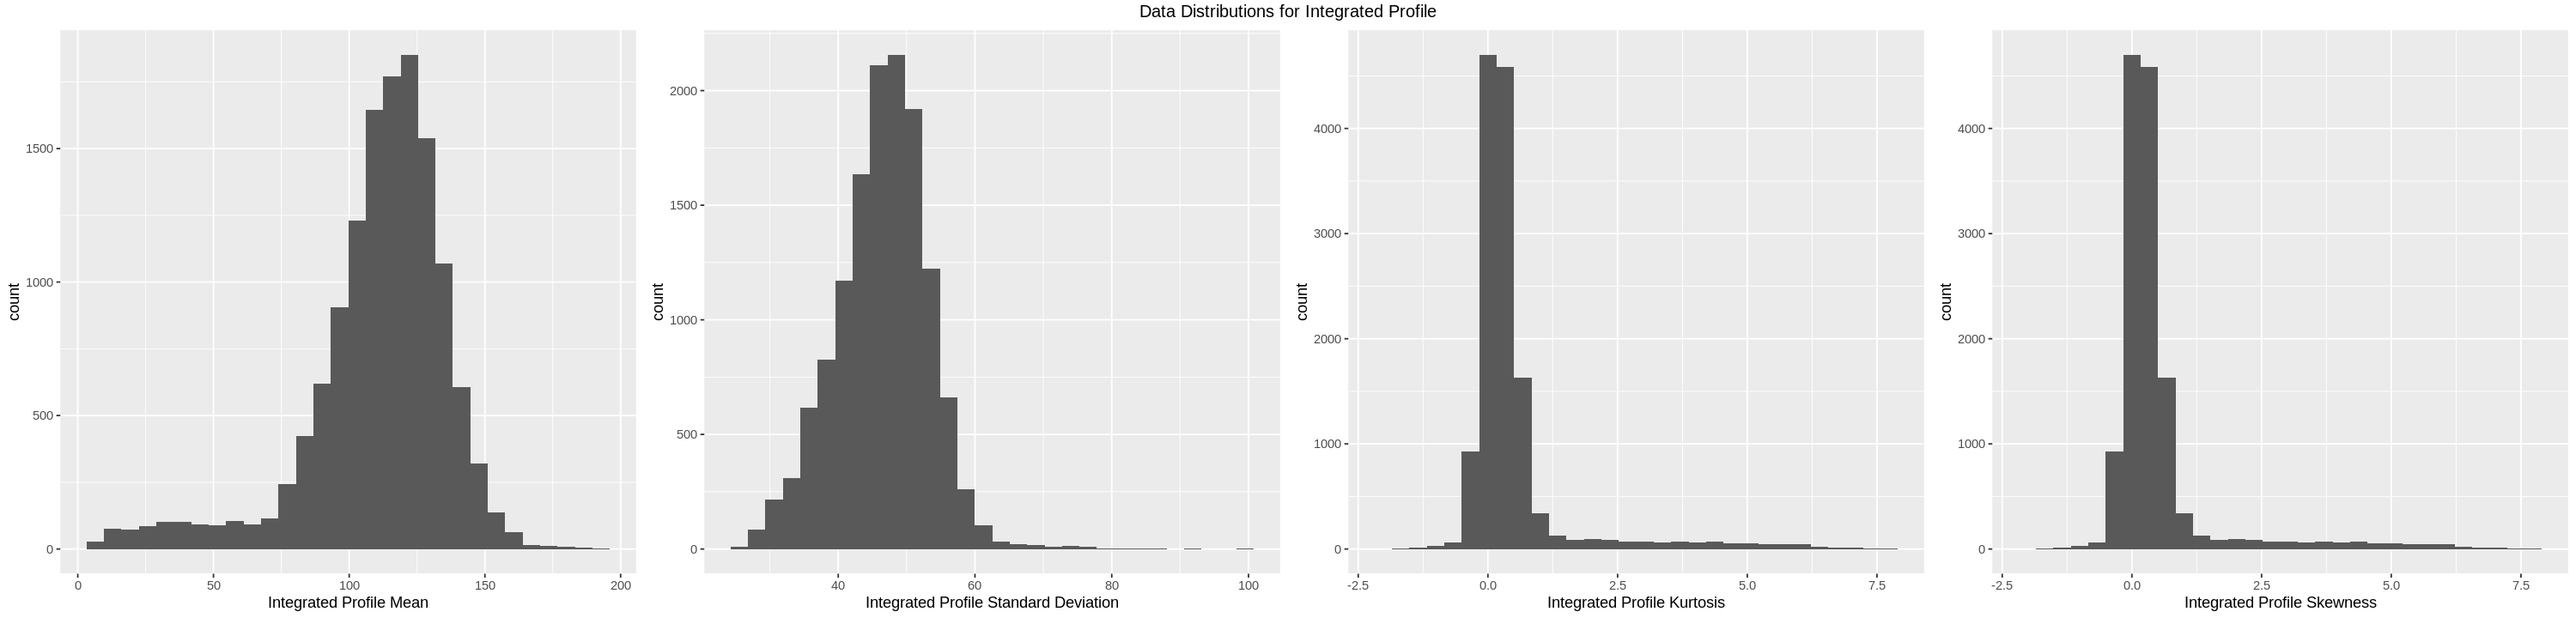

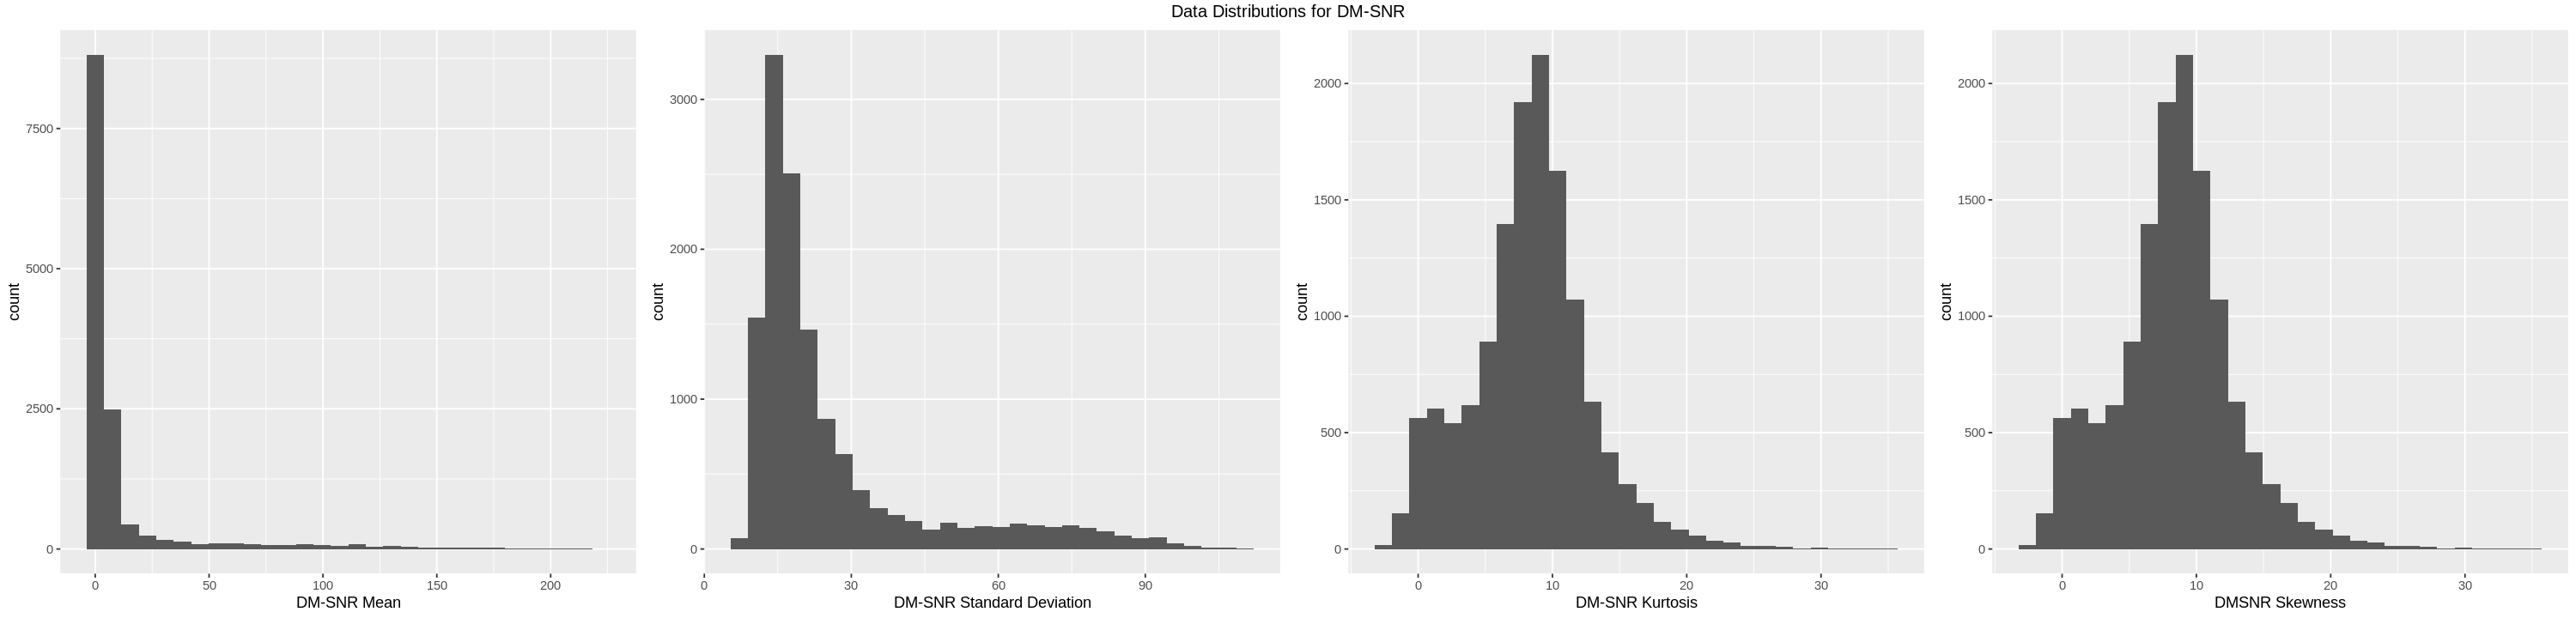

In [6]:
library(gridExtra)
options(repr.plot.width=25, repr.plot.height=6)

vis_mean_ip <- ggplot(htru_train, aes(x = mean_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Mean')
vis_sd_ip <- ggplot(htru_train, aes(x = sd_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Standard Deviation')
vis_kurtosis_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Kurtosis')
vis_skew_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram() + 
    labs(x = 'Integrated Profile Skewness')
vis_mean_dmsnr <- ggplot(htru_train, aes(x = mean_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Mean')
vis_sd_dmsnr <- ggplot(htru_train, aes(x = sd_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Standard Deviation')
vis_kurtosis_dmsnr <- ggplot(htru_train, aes(x = kurtosis_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DM-SNR Kurtosis')
vis_skew_dmsnr <- ggplot(htru_train, aes(x = kurtosis_dmsnr)) +
    geom_histogram() + 
    labs(x = 'DMSNR Skewness')

grid.arrange(vis_mean_ip, vis_sd_ip, vis_kurtosis_ip, vis_skew_ip, nrow = 1, top = 'Data Distributions for Integrated Profile')
grid.arrange(vis_mean_dmsnr, vis_sd_dmsnr, vis_kurtosis_dmsnr, vis_skew_dmsnr, nrow = 1, top = 'Data Distributions for DM-SNR')

## Methods

One way we will visualise our results is using a scatter plot. We will plot the class data predicted on the same plot as our model and the actual classes from the testing data, differentiating them by colour. Using this visualisation, we will be able to observe the accuracy of our model with just a cursory glance. We will build a K-means clustering algorithm that will work to identify a star as being a pulsar or not based on the data points that are around it. To build the K-means clustering algorithm we will split the data into a test set and a training set using the initial split function in R. After doing so we will specify that the proportion in the training set will be 75% and 25%. These proportions are chosen because these will allow us to build a more robust classifier. For the K means classifier,we will centre and scale the data as well. For the classifier, we intend to use the mean, skewness, kurtosis, and standard deviation from the integrated profile, as these focus on the intensity of the wave and the phase in which it is at. Hence, the integrated profile would be more appropriate for determining if a star is a pulsar because it takes into consideration the intensity of each of the signals. Therefore, we believe that the intensity of the signals is the best characteristic to determine if the star is pulsar. 

## Expected Outcomes and Significance

Expected outcomes and significance:
By executing our visualisation method, we expect to find out if a signal with particular characteristics is a pulsar star or not. This is helpful since it can help scientists study gravitational waves.  By classifying if a star is a pulsar or not, scientists are able to study extreme states of matter, study other planets, measure cosmic distances, and be wary of gravitational waves for potential collisions. Through this, scientists and scholars are able to explore questions such as: 
- How do pulsar and non-pulsar stars differ in terms of the mean, standard deviation, kurtosis, and skewness? Is there a specific value threshold -that classifies if it is pulsar or not? 
- Are both curves (integrated profile and DM-SNR) important towards training a model that can identify pulsars? Can we use only one profile to train a model that accurately identifies pulsar stars? 
- What is the proportion of pulsar and non-pulsar stars? 
